# Dataset Research

> We will use SQL queries just for experience.

In [1]:
import psycopg
import pandas as pd

In [2]:
with open("../../../JupyterFiles/dbpass.txt", "r") as pwrdfile:
    usrnm = pwrdfile.readline().strip()
    pwrd = pwrdfile.readline().strip()
    dbnm = pwrdfile.readline().strip()

In [3]:
with psycopg.connect(dbname=dbnm, user=usrnm, password=pwrd) as conn:
    with conn.cursor() as cur:

        cur.execute("SET search_path TO mvp_schema")

        cur.execute("""
            SELECT * FROM mvp_dataset md
            JOIN series_list sl on sl.series_id = md.series_id
            """)
        
        dataset = cur.fetchall()

        cur.execute("""SELECT attname AS column_name
FROM pg_catalog.pg_attribute
JOIN pg_catalog.pg_class ON pg_class.oid = pg_attribute.attrelid
JOIN pg_catalog.pg_namespace ON pg_namespace.oid = pg_class.relnamespace
WHERE pg_namespace.nspname = 'mvp_schema' AND pg_class.relname = 'mvp_dataset' AND pg_attribute.attnum > 0 AND NOT pg_attribute.attisdropped
UNION ALL
SELECT attname AS column_name
FROM pg_catalog.pg_attribute
JOIN pg_catalog.pg_class ON pg_class.oid = pg_attribute.attrelid
JOIN pg_catalog.pg_namespace ON pg_namespace.oid = pg_class.relnamespace
WHERE pg_namespace.nspname = 'mvp_schema' AND pg_class.relname = 'series_list' AND pg_attribute.attnum > 0 AND NOT pg_attribute.attisdropped;
""")

        colnames = cur.fetchall()

        df = pd.DataFrame(data=dataset)

In [4]:
coln = [tup[0] for tup in colnames]
df.columns = coln

In [5]:
df.head()

,country_code,series_id,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,series_id,series_name
0,ARG,1,19.366,18.983,18.756,18.453,18.352,18.353,18.194,18.005,...,17.729,17.632,17.504,17.346,16.824,16.206,15.187,14.783,1,"Birth rate, crude (per 1,000 people)"
1,AUT,1,9.8,9.4,9.7,9.5,9.7,9.5,9.4,9.2,...,9.4,9.4,9.6,9.8,10.0,10.0,9.7,9.6,1,"Birth rate, crude (per 1,000 people)"
2,BLR,1,9.4,9.2,8.9,9.0,9.1,9.3,9.9,10.7,...,12.2,12.5,12.5,12.5,12.4,10.8,9.9,9.3,1,"Birth rate, crude (per 1,000 people)"
3,BEL,1,11.4,11.2,10.9,11.0,11.3,11.4,11.6,11.7,...,11.5,11.3,11.2,10.8,10.8,10.5,10.4,10.2,1,"Birth rate, crude (per 1,000 people)"
4,CRI,1,19.788,19.104,18.12,17.656,17.228,16.99,16.797,16.823,...,15.483,15.093,14.852,14.522,14.145,13.926,13.562,12.847,1,"Birth rate, crude (per 1,000 people)"


In [6]:
df.drop('series_id',axis=1,inplace=True)

In [7]:
df.head()

,country_code,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,series_name
0,ARG,19.366,18.983,18.756,18.453,18.352,18.353,18.194,18.005,17.812,...,17.806,17.729,17.632,17.504,17.346,16.824,16.206,15.187,14.783,"Birth rate, crude (per 1,000 people)"
1,AUT,9.8,9.4,9.7,9.5,9.7,9.5,9.4,9.2,9.3,...,9.3,9.4,9.4,9.6,9.8,10.0,10.0,9.7,9.6,"Birth rate, crude (per 1,000 people)"
2,BLR,9.4,9.2,8.9,9.0,9.1,9.3,9.9,10.7,11.1,...,11.5,12.2,12.5,12.5,12.5,12.4,10.8,9.9,9.3,"Birth rate, crude (per 1,000 people)"
3,BEL,11.4,11.2,10.9,11.0,11.3,11.4,11.6,11.7,11.9,...,11.7,11.5,11.3,11.2,10.8,10.8,10.5,10.4,10.2,"Birth rate, crude (per 1,000 people)"
4,CRI,19.788,19.104,18.12,17.656,17.228,16.99,16.797,16.823,16.899,...,15.772,15.483,15.093,14.852,14.522,14.145,13.926,13.562,12.847,"Birth rate, crude (per 1,000 people)"


So. The main question is do we have any correlations?

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [80]:
df.country_code.unique()

array(['ARG', 'AUT', 'BLR', 'BEL', 'CRI', 'DNK', 'DOM', 'SLV', 'FIN',
       'GRC', 'LUX', 'MDA', 'NOR', 'PER', 'RUS', 'SWE', 'THA', 'USA'],
      dtype=object)

In [140]:
def dataset_analyzer():
    # Create a list with all dataframes of each country
    dfdict = {}
    for cc in df.country_code.unique():
        dfdict[cc] = df.loc[df.country_code == cc].drop(["country_code"], axis=1).set_index("series_name").transpose()

    # Changing data type to float
    for dataframe in dfdict.values():
        for col in dataframe.columns: dataframe[col] = dataframe[col].astype(float)

    # That piece is needed if you want to see full output. Showing all good correlations in datasets with pvalue > 5%:
    # for country, dataframe in dfdict.items():
    #     print(f"Country: {country}\n")
    #     print("Female population:\n")
    #     for col in dataframe.columns:
    #         if pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, female (per 100,000 female population)'].to_list())[1]<0.05 and col.find("Suicide")==-1:
    #             print(f"{col},\n{pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, female (per 100,000 female population)'].to_list())}\n")
    #     print("Male Population:\n")
    #     for col in dataframe.columns:
    #         if pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, male (per 100,000 male population)'].to_list())[1]<0.05 and col.find("Suicide")==-1:
    #             print(f"{col},\n{pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, male (per 100,000 male population)'].to_list())}\n")
    #     print("Full Population:\n")
    #     for col in dataframe.columns:
    #         if pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate (per 100,000 population)'].to_list())[1]<0.05 and col.find("Suicide")==-1:
    #             print(f"{col},\n{pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate (per 100,000 population)'].to_list())}\n")

    # We are creating data output here
    serieslist = {}
    serieslist["Female"] = {}
    serieslist["Male"] = {}
    serieslist["Full"] = {}
    for key in serieslist:
        for s in dfdict["ARG"].columns: 
            if s.find("Suicide")==-1:
                serieslist[key][s] = {}

    # Saving all good correlations in datasets with pvalue < 5%:
    for country, dataframe in dfdict.items():
        for col in dataframe.columns:
            pearsonr_val = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, female (per 100,000 female population)'].to_list())
            if pearsonr_val[1]<0.05 and col.find("Suicide")==-1 and (pearsonr_val[0]>0.5 or pearsonr_val[0]<-0.5):
                serieslist["Female"][col][country] = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, female (per 100,000 female population)'].to_list())
        for col in dataframe.columns:
            pearsonr_val = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, male (per 100,000 male population)'].to_list())
            if pearsonr_val[1]<0.05 and col.find("Suicide")==-1 and (pearsonr_val[0]>0.5 or pearsonr_val[0]<-0.5):
                serieslist["Male"][col][country] = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate, male (per 100,000 male population)'].to_list())
        for col in dataframe.columns:
            pearsonr_val = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate (per 100,000 population)'].to_list())
            if pearsonr_val[1]<0.05 and col.find("Suicide")==-1 and (pearsonr_val[0]>0.5 or pearsonr_val[0]<-0.5):
                serieslist["Full"][col][country] = pearsonr(dataframe[col].to_list(), dataframe['Suicide mortality rate (per 100,000 population)'].to_list())

    return serieslist

In [146]:
import numpy as np

correlations = dataset_analyzer()
for sex, series_data in correlations.items():
    print(f"{sex}\n")
    for series, country_data in series_data.items():
        print(f"""{series}
        {len(country_data)}/{len(df.country_code.unique())} countries correlate
        Average stval = {np.mean([pearsres[0] for pearsres in country_data.values()])}
        Average pval = {np.mean([pearsres[1] for pearsres in country_data.values()])}""")

Female

Birth rate, crude (per 1,000 people)
        11/18 countries correlate
        Average stval = 0.06242567743033596
        Average pval = 0.004963032962615992
Control of Corruption  Percentile Rank
        6/18 countries correlate
        Average stval = -0.25747707970169614
        Average pval = 0.007964258182436623
Death rate, crude (per 1,000 people)
        8/18 countries correlate
        Average stval = 0.24086634469144466
        Average pval = 0.002360834211168987
Domestic general government health expenditure per capita (current US$)
        12/18 countries correlate
        Average stval = -0.47299812612578945
        Average pval = 0.002729814968221174
GDP per capita (current US$)
        12/18 countries correlate
        Average stval = -0.45330964825986264
        Average pval = 0.0024830183122721157
Income share held by highest 10%
        9/18 countries correlate
        Average stval = 0.35588145161085805
        Average pval = 0.0034533400100982357
Land Surfac

C:\Users\baakh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\baakh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [142]:
for sex, series_data in correlations.items():
    print(f"{sex}\n")
    for series, country_data in series_data:
        len()

{'Female': {'Birth rate, crude (per 1,000 people)': {'BLR': PearsonRResult(statistic=-0.5174209209801038, pvalue=0.019465276920316063),
   'DNK': PearsonRResult(statistic=0.8058122558491874, pvalue=1.7988799246849965e-05),
   'DOM': PearsonRResult(statistic=-0.7711930742943107, pvalue=6.869467053731712e-05),
   'SLV': PearsonRResult(statistic=0.8606085320327788, pvalue=1.1250290036262497e-06),
   'FIN': PearsonRResult(statistic=0.5675920140275165, pvalue=0.009045426405142507),
   'GRC': PearsonRResult(statistic=-0.8332591976113928, pvalue=5.078766126440651e-06),
   'LUX': PearsonRResult(statistic=0.5042084840186208, pvalue=0.023394229455875777),
   'PER': PearsonRResult(statistic=0.8476502320508306, pvalue=2.3825931231914307e-06),
   'RUS': PearsonRResult(statistic=-0.6360533334349945, pvalue=0.00257305275280049),
   'THA': PearsonRResult(statistic=0.8031694575141232, pvalue=2.0106804801834486e-05),
   'USA': PearsonRResult(statistic=-0.94443199743856, pvalue=3.9180181280728725e-10)},


In [ ]:
'Income share held by highest 10%'
'Income share held by highest 10%'

In [107]:
dataset_analyzer()

Country: ARG

Female population:

GDP per capita (current US$),
PearsonRResult(statistic=-0.518407049448169, pvalue=0.019194596909299328)

Income share held by highest 10%,
PearsonRResult(statistic=0.6864185345158998, pvalue=0.0008311286751262193)

Life expectancy at birth, male (years),
PearsonRResult(statistic=-0.509885022019419, pvalue=0.02163574300171743)

Life expectancy at birth, total (years),
PearsonRResult(statistic=-0.47775485143969676, pvalue=0.033135095335862015)

Social contributions (% of revenue),
PearsonRResult(statistic=-0.47424553083894516, pvalue=0.03463521263505782)

Male Population:

Income share held by highest 10%,
PearsonRResult(statistic=0.6569064781050336, pvalue=0.0016516755965468722)

Life expectancy at birth, female (years),
PearsonRResult(statistic=-0.48306013905547956, pvalue=0.03096417643850512)

Life expectancy at birth, male (years),
PearsonRResult(statistic=-0.5298480948289968, pvalue=0.01626820222920281)

Life expectancy at birth, total (years),
Pear

In [48]:
df_arg = df.loc[df.country_code == "ARG"].drop(["country_code"], axis=1).set_index("series_name").transpose()
for col in df_arg.columns: df_arg[col] = df_arg[col].astype(float)

In [49]:
df_arg.head()

series_name,"Birth rate, crude (per 1,000 people)",Control of Corruption Percentile Rank,"Death rate, crude (per 1,000 people)",Domestic general government health expenditure per capita (current US$),GDP per capita (current US$),Income share held by highest 10%,Land Surface Temperature,"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)","Life expectancy at birth, total (years)",Social contributions (% of revenue),"Suicide mortality rate (per 100,000 population)","Suicide mortality rate, female (per 100,000 female population)","Suicide mortality rate, male (per 100,000 male population)",Voice and Accountability Percentile Rank
2000,19.366,52.1276588439941,7.6,387.92160925,7666.51783423783,37.7,22.6250952,77.223,70.583,73.926,23.4222563056389,9.1,3.4,15.2,61.1940307617188
2001,18.983,46.96330070495605,7.549,370.28302256,7168.97587232911,39.5,24.8765655,77.59,70.749,74.186,22.8402715311037,10.3,4.0,16.9,58.70646858215335
2002,18.756,41.798942565918,7.518,122.12313832,2579.48876933284,40.5,23.876547,78.075,70.752,74.408,19.678291491537,10.2,4.2,16.6,56.2189064025879
2003,18.453,40.2116394042969,7.864,143.50332189,3333.15290388997,37.7,24.6244864,77.276,70.83,74.08,16.2280570401266,9.7,3.8,15.9,61.1940307617188
2004,18.352,39.9014778137207,7.48,161.42892646,4258.16026060875,35.2,24.1243079,78.103,71.53,74.855,16.5557606385361,8.7,3.6,14.2,59.6153831481934


Female population:

Birth rate, crude (per 1,000 people),
PearsonRResult(statistic=0.3142943154556797, pvalue=0.1771571720112144)

Control of Corruption  Percentile Rank,
PearsonRResult(statistic=-0.05568237288878417, pvalue=0.8156330641964058)

Death rate, crude (per 1,000 people),
PearsonRResult(statistic=-0.08210220811271991, pvalue=0.7307621061745648)

Domestic general government health expenditure per capita (current US$),
PearsonRResult(statistic=-0.4151126560096151, pvalue=0.06875248896776097)

GDP per capita (current US$),
PearsonRResult(statistic=-0.518407049448169, pvalue=0.019194596909299328)

Income share held by highest 10%,
PearsonRResult(statistic=0.6864185345158998, pvalue=0.0008311286751262193)

Land Surface Temperature,
PearsonRResult(statistic=-0.24893597548426077, pvalue=0.28988755443751496)

Life expectancy at birth, female (years),
PearsonRResult(statistic=-0.43024387030137917, pvalue=0.05828643009941546)

Life expectancy at birth, male (years),
PearsonRResult(sta

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [53]:
df_arg.columns

Index(['Birth rate, crude (per 1,000 people)',
       'Control of Corruption  Percentile Rank',
       'Death rate, crude (per 1,000 people)',
       'Domestic general government health expenditure per capita (current US$)',
       'GDP per capita (current US$)', 'Income share held by highest 10%',
       'Land Surface Temperature', 'Life expectancy at birth, female (years)',
       'Life expectancy at birth, male (years)',
       'Life expectancy at birth, total (years)',
       'Social contributions (% of revenue)',
       'Suicide mortality rate (per 100,000 population)',
       'Suicide mortality rate, female (per 100,000 female population)',
       'Suicide mortality rate, male (per 100,000 male population)',
       'Voice and Accountability  Percentile Rank'],
      dtype='object', name='series_name')

<AxesSubplot: >

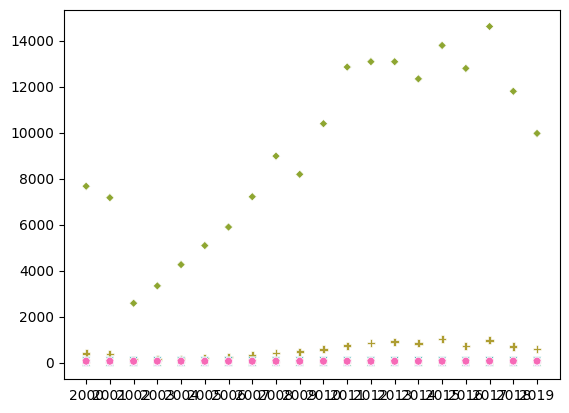

In [51]:
sns.scatterplot(df_arg,legend=False)

In [17]:
df.loc[df.country_code == "ARG"]

,country_code,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,series_name
0,ARG,19.366,18.983,18.756,18.453,18.352,18.353,18.194,18.005,17.812,...,17.806,17.729,17.632,17.504,17.346,16.824,16.206,15.187,14.783,"Birth rate, crude (per 1,000 people)"
19,ARG,52.1276588439941,46.96330070495605,41.798942565918,40.2116394042969,39.9014778137207,43.4146347045898,43.4146347045898,44.1747589111328,39.8058242797852,...,43.6018943786621,40.2843589782715,40.7582931518555,35.5769233703613,34.1346168518066,47.1153831481934,45.6730766296387,55.288459777832,54.3269233703613,Control of Corruption Percentile Rank
36,ARG,7.6,7.549,7.518,7.864,7.48,7.423,7.369,7.748,7.467,...,7.51,7.394,7.494,7.447,7.543,7.947,7.692,7.68,7.6,"Death rate, crude (per 1,000 people)"
54,ARG,387.92160925,370.28302256,122.12313832,143.50332189,161.42892646,201.86562662,239.76034285,310.67294178,411.30692067,...,728.91668551,854.26357877,904.13348228,841.48920147,1021.71045491,716.4738335,966.72963849,692.61743135,589.92823278,Domestic general government health expenditure...
72,ARG,7666.51783423783,7168.97587232911,2579.48876933284,3333.15290388997,4258.16026060875,5086.62776073134,5890.97800169795,7210.59554755899,8977.50685093365,...,12848.8641969705,13082.664325572,13080.2547323367,12334.7982453893,13789.060424772,12790.2424732447,14613.041824658,11795.1593866287,9963.6725062053,GDP per capita (current US$)
90,ARG,37.7,39.5,40.5,37.7,35.2,34.9,33.7,33.7,32.4,...,31.0,29.7,29.4,29.9,30.201453019050632,30.4,29.7,29.8,31.0,Income share held by highest 10%
109,ARG,22.6250952,24.8765655,23.876547,24.6244864,24.1243079,24.6252267,25.2546679,24.1253293,26.126321,...,25.1256966,24.8755786,25.3754258,24.3759063,24.375263,23.7522927,24.375667,24.8753089,24.8761522,Land Surface Temperature
126,ARG,77.223,77.59,78.075,77.276,78.103,78.527,78.716,78.515,78.927,...,79.322,79.953,79.927,80.004,80.188,79.67,80.085,80.329,80.681,"Life expectancy at birth, female (years)"
144,ARG,70.583,70.749,70.752,70.83,71.53,71.692,72.066,71.487,72.276,...,72.841,72.939,73.011,73.424,73.294,72.933,73.526,73.631,73.857,"Life expectancy at birth, male (years)"
162,ARG,73.926,74.186,74.408,74.08,74.855,75.139,75.433,75.006,75.641,...,76.124,76.467,76.491,76.755,76.76,76.308,76.833,76.999,77.284,"Life expectancy at birth, total (years)"
